In [1]:
import os
import numpy as np

import logging
import six
import radiomics
from radiomics import featureextractor
import SimpleITK as sitk

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt

import image_perturbation as impt

import glob
import datetime


import file_structure
(origdir,basedir,imagedir,normdir,splitdir,out_dir,model_dir) = file_structure.file_dirs('texture')

modal_list = ['FLAIR','T1', 'T1post','T2']

#load the parameters for extractor
params = 'texture_settings.yaml'
extractor = featureextractor.RadiomicsFeaturesExtractor(params)

# it is already pre-processed such that every voxel is 1x1x1mm.
data_spacing = [1,1,1]

# set up a logger
# Get the PyRadiomics logger (default log-level = INFO)
logger = radiomics.logger
logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

# Write out all log entries to a file
handler = logging.FileHandler(filename='Log_2D_test.txt', mode='w')
formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [2]:
modal = 'FLAIR'
mask = np.load(os.path.join(splitdir,'slices_mask.npy'))
img = {}
inten_dic = {}
for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_%s.npy' % (modal)))

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]

    inten_range = np.zeros((n_slices,2))

    for i in range(n_slices):
        inten_range[i,0], inten_range[i,1] = img[modal][i,:,:,2].min(), img[modal][i,:,:,2].max()

    inten_dic[modal] = inten_range


features = {}
for modal in modal_list:
    features[modal] = {}

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]

    for slice_ind in range(n_slices):
        features[modal][slice_ind] = {}

        # for view_ind in range(len(views)):
            # pick slice and view
        img_slice = img[modal][slice_ind,:,:,2]
        mask_slice = mask[slice_ind,:,:,2]

        #convert numpy array into sitk

        sitk_img = sitk.GetImageFromArray(img_slice)
        sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_img = sitk.JoinSeries(sitk_img)

        sitk_mask = sitk.GetImageFromArray(mask_slice)
        sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
        sitk_mask = sitk.JoinSeries(sitk_mask)
        sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

        features[modal][slice_ind]['z']=extractor.execute(sitk_img, sitk_mask)

# obtain feature names
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features['T1'][1]['z'] )))

feature_names_all = []

for modal in modal_list:

    feature_names_all.append([elemt + '_'+ modal for elemt in feature_names])

feature_names_all_flattened = [val for sublist in feature_names_all for val in sublist]

# remove "original_"
feature_names_all_flattened = [elmt[9:] for elmt in feature_names_all_flattened]

print('number of features are ', len(feature_names_all_flattened))

#Make a numpy array of all the values
samples = np.zeros( (n_slices, len(feature_names)*len(modal_list) ) )
for slice_ind in range(n_slices):
    a = np.array([])

    for modal in modal_list:

        for feature_name in feature_names:

                a = np.append(a, features[modal][slice_ind]['z'][feature_name]) 
    samples[slice_ind,:] = a

samples = np.nan_to_num(samples)
np.save(os.path.join(splitdir,'slices_texture_features.npy'),samples)
np.save(os.path.join(splitdir,'texture_feature_names.npy'), feature_names_all_flattened)

NameError: name 'np' is not defined

(520, 284, 284, 3)


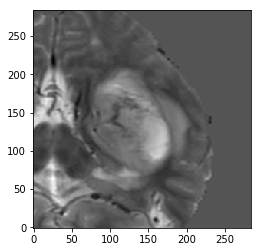

In [8]:
modal = 'FLAIR'
mask_or = np.load(os.path.join(splitdir,'slices_exp_mask.npy'))
mask = (mask_or > 0) * 1
img = {}
inten_dic = {}
for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_exp_%s.npy' % (modal)))

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]

    inten_range = np.zeros((n_slices,2))

    for i in range(n_slices):
        inten_range[i,0], inten_range[i,1] = img[modal][i,:,:,2].min(), img[modal][i,:,:,2].max()

    inten_dic[modal] = inten_range


#for modal in modal_list:

# [n_slices, x_dim, y_dim, views]
n_slices = img[modal].shape[0]
slice_ind = 20
#for slice_ind in range(n_slices):

# for view_ind in range(len(views)):
    # pick slice and view
img_slice = img[modal][slice_ind,:,:,2]
mask_slice = mask[slice_ind,:,:,2]
mask_or_slice = mask_or[slice_ind,:,:,2]


plt.imshow(img_slice.T, cmap="gray", origin="lower")  
print(img[modal].shape)
plt.show()

In [11]:
tau_vec = np.arange(-.28,.28+.2,.2)
temp = {}
for i in range(len(tau_vec)):
    tau = tau_vec[i]
    temp[i] = {}
    adj_mask = impt.grow_shrink_image(mask_slice,tau)
    sitk_img = sitk.GetImageFromArray(img_slice)
    sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
    sitk_img = sitk.JoinSeries(sitk_img)

    sitk_mask = sitk.GetImageFromArray(adj_mask)
    sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
    sitk_mask = sitk.JoinSeries(sitk_mask)
    sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

    temp[i]['z']=extractor.execute(sitk_img, sitk_mask)
print(temp)

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


{0: {'z': OrderedDict([('diagnostics_Versions_PyRadiomics', '2.1.0'), ('diagnostics_Versions_Numpy', '1.14.3'), ('diagnostics_Versions_SimpleITK', '1.1.0'), ('diagnostics_Versions_PyWavelet', '0.5.2'), ('diagnostics_Versions_Python', '3.6.5'), ('diagnostics_Configuration_Settings', {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}), ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}), ('diagnostics_Image-original_Hash', 'f39e5a38dbff8955fc627e7385a29838f0f9f17b'), ('diagnostics_Image-original_Spacing', (1.0, 1.0, 1.0)), ('diagnostics_Image-original_Size', (284, 284, 1)), ('diagnostics_Image-original_Mean', 0.39065770808260136), ('diagnostics_Image-original_Minimum', -3.016239643096924), ('diag

In [3]:
mask = np.load(os.path.join(splitdir,'slices_exp_mask.npy'))
img = {}
inten_dic = {}
for modal in modal_list:
    #load image and mask
    img[modal] = np.load(os.path.join(splitdir,'slices_exp_%s.npy' % (modal)))

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]

    inten_range = np.zeros((n_slices,2))

    for i in range(n_slices):
        inten_range[i,0], inten_range[i,1] = img[modal][i,:,:,2].min(), img[modal][i,:,:,2].max()

    inten_dic[modal] = inten_range


tau_vec = np.arange(-.28,.28+.2,.02)
features = {}
for modal in modal_list:
    features[modal] = {}

    # [n_slices, x_dim, y_dim, views]
    n_slices = img[modal].shape[0]

    for slice_ind in range(n_slices):
        print('%s - %d' % (modal,slice_ind), datetime.datetime.now().time())
        features[modal][slice_ind] = {}

        # for view_ind in range(len(views)):
            # pick slice and view
        img_slice = img[modal][slice_ind,:,:,2]
        mask_slice = (mask[slice_ind,:,:,2] > 0) * 1

        for adi in range(len(tau_vec)):
            tau = tau_vec[adi]
            features[modal][slice_ind][adi] = {}
            adj_mask = impt.grow_shrink_image(mask_slice,tau)
            #convert numpy array into sitk

            sitk_img = sitk.GetImageFromArray(img_slice)
            sitk_img.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
            sitk_img = sitk.JoinSeries(sitk_img)

            sitk_mask = sitk.GetImageFromArray(adj_mask)
            sitk_mask.SetSpacing((float(data_spacing[0]), float(data_spacing[1]), float(data_spacing[2]) ))
            sitk_mask = sitk.JoinSeries(sitk_mask)
            sitk_mask = sitk.Cast(sitk_mask, sitk.sitkInt32)

            features[modal][slice_ind][adi]['z']=extractor.execute(sitk_img, sitk_mask)

# obtain feature names
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features['T1'][1][0]['z'] )))

feature_names_all = []

for modal in modal_list:

    feature_names_all.append([elemt + '_'+ modal for elemt in feature_names])

feature_names_all_flattened = [val for sublist in feature_names_all for val in sublist]

# remove "original_"
feature_names_all_flattened = [elmt[9:] for elmt in feature_names_all_flattened]

print('number of features are ', len(feature_names_all_flattened))

#Make a numpy array of all the values
samples = np.zeros( (n_slices, len(feature_names)*len(modal_list) ,len(tau_vec)) )
for adi in range(len(tau_vec)):
    for slice_ind in range(n_slices):
        a = np.array([])

        for modal in modal_list:

            for feature_name in feature_names:

                    a = np.append(a, features[modal][slice_ind][adi]['z'][feature_name]) 
        samples[slice_ind,:,adi] = a

samples = np.nan_to_num(samples)
print(samples)

FLAIR - 0 16:08:49.448199
FLAIR - 1 16:09:12.918436
FLAIR - 2 16:09:49.609778
FLAIR - 3 16:10:11.390564
FLAIR - 4 16:10:39.481089
FLAIR - 5 16:11:33.584630
FLAIR - 6 16:12:15.572024
FLAIR - 7 16:12:53.025389
FLAIR - 8 16:13:35.340654
FLAIR - 9 16:14:07.480924
FLAIR - 10 16:14:34.428439
FLAIR - 11 16:15:18.050147
FLAIR - 12 16:15:59.725750
FLAIR - 13 16:16:41.680022
FLAIR - 14 16:17:17.323585
FLAIR - 15 16:17:44.246035
FLAIR - 16 16:18:00.280553
FLAIR - 17 16:18:32.111002
FLAIR - 18 16:19:12.471077
FLAIR - 19 16:19:46.223625
FLAIR - 20 16:20:19.499908
FLAIR - 21 16:21:07.499253
FLAIR - 22 16:21:58.217812
FLAIR - 23 16:22:45.921372
FLAIR - 24 16:23:35.339504
FLAIR - 25 16:24:11.655830
FLAIR - 26 16:24:50.512424
FLAIR - 27 16:25:30.034277
FLAIR - 28 16:26:28.017108
FLAIR - 29 16:27:14.894476
FLAIR - 30 16:28:04.177227
FLAIR - 31 16:28:43.770269
FLAIR - 32 16:29:22.096950
FLAIR - 33 16:29:48.440843
FLAIR - 34 16:30:21.287988
FLAIR - 35 16:30:55.760445
FLAIR - 36 16:31:44.198954
FLAIR - 37 

FLAIR - 297 19:36:48.959684
FLAIR - 298 19:37:47.276401
FLAIR - 299 19:38:41.456142
FLAIR - 300 19:39:32.707113
FLAIR - 301 19:40:22.138257
FLAIR - 302 19:41:19.636803
FLAIR - 303 19:42:11.858349
FLAIR - 304 19:42:56.481738
FLAIR - 305 19:43:58.265654
FLAIR - 306 19:44:55.199702
FLAIR - 307 19:45:55.052496
FLAIR - 308 19:46:46.666429
FLAIR - 309 19:47:34.302810
FLAIR - 310 19:48:26.431110
FLAIR - 311 19:49:28.577989
FLAIR - 312 19:50:28.208190
FLAIR - 313 19:51:19.955478
FLAIR - 314 19:52:18.137840
FLAIR - 315 19:53:21.044735
FLAIR - 316 19:54:19.386527
FLAIR - 317 19:55:26.839905
FLAIR - 318 19:56:25.347494
FLAIR - 319 19:57:25.771179
FLAIR - 320 19:58:17.241051
FLAIR - 321 19:58:55.671248
FLAIR - 322 19:59:30.444643
FLAIR - 323 20:00:06.792074
FLAIR - 324 20:00:48.047527
FLAIR - 325 20:01:24.705783
FLAIR - 326 20:02:03.795491
FLAIR - 327 20:02:27.694897
FLAIR - 328 20:03:05.205414
FLAIR - 329 20:03:41.613005
FLAIR - 330 20:04:18.601137
FLAIR - 331 20:04:57.203551
FLAIR - 332 20:05:33

T1 - 82 23:08:32.378975
T1 - 83 23:09:27.053028
T1 - 84 23:10:13.114231
T1 - 85 23:10:41.205759
T1 - 86 23:11:11.961355
T1 - 87 23:11:32.993154
T1 - 88 23:11:54.497205
T1 - 89 23:12:18.139930
T1 - 90 23:13:02.240933
T1 - 91 23:13:40.999761
T1 - 92 23:14:34.049506
T1 - 93 23:15:20.806553
T1 - 94 23:16:12.524765
T1 - 95 23:16:35.811546
T1 - 96 23:17:06.175101
T1 - 97 23:17:29.304465
T1 - 98 23:18:06.163253
T1 - 99 23:18:38.819893
T1 - 100 23:19:08.821488
T1 - 101 23:19:42.309334
T1 - 102 23:20:15.257747
T1 - 103 23:20:58.741110
T1 - 104 23:21:42.749869
T1 - 105 23:22:21.656090
T1 - 106 23:23:01.251137
T1 - 107 23:23:52.743748
T1 - 108 23:24:44.914159
T1 - 109 23:25:28.686289
T1 - 110 23:26:09.079454
T1 - 111 23:26:54.487925
T1 - 112 23:27:44.688108
T1 - 113 23:28:23.924204
T1 - 114 23:29:15.256391
T1 - 115 23:29:57.596970
T1 - 116 23:30:38.534835
T1 - 117 23:31:11.863468
T1 - 118 23:31:53.135219
T1 - 119 23:32:25.053100
T1 - 120 23:32:57.092300
T1 - 121 23:33:40.866709
T1 - 122 23:34:36.

T1 - 411 03:04:39.164784
T1 - 412 03:05:00.096447
T1 - 413 03:05:23.044472
T1 - 414 03:05:52.121797
T1 - 415 03:06:16.113598
T1 - 416 03:06:45.066592
T1 - 417 03:07:11.048688
T1 - 418 03:07:38.815528
T1 - 419 03:08:08.047262
T1 - 420 03:08:36.802731
T1 - 421 03:09:09.538786
T1 - 422 03:09:55.056599
T1 - 423 03:10:44.138817
T1 - 424 03:11:19.373296
T1 - 425 03:12:09.586514
T1 - 426 03:12:45.727397
T1 - 427 03:13:30.157273
T1 - 428 03:14:08.390707
T1 - 429 03:14:54.393756
T1 - 430 03:15:39.942599
T1 - 431 03:16:17.061076
T1 - 432 03:16:57.150435
T1 - 433 03:17:33.424673
T1 - 434 03:18:09.107341
T1 - 435 03:18:43.241901
T1 - 436 03:19:20.431567
T1 - 437 03:19:56.305744
T1 - 438 03:20:34.939240
T1 - 439 03:21:10.381269
T1 - 440 03:21:45.722030
T1 - 441 03:22:08.673923
T1 - 442 03:22:48.743228
T1 - 443 03:23:13.428720
T1 - 444 03:23:38.192419
T1 - 445 03:24:22.780714
T1 - 446 03:24:49.754277
T1 - 447 03:25:36.075168
T1 - 448 03:26:23.147052
T1 - 449 03:26:51.273674
T1 - 450 03:27:33.230988


T1post - 193 06:30:04.195912
T1post - 194 06:30:55.585250
T1post - 195 06:31:36.773524
T1post - 196 06:32:19.358504
T1post - 197 06:32:54.841643
T1post - 198 06:33:38.825334
T1post - 199 06:34:07.713977
T1post - 200 06:34:36.298814
T1post - 201 06:35:33.728178
T1post - 202 06:36:26.707734
T1post - 203 06:36:53.049621
T1post - 204 06:37:19.397523
T1post - 205 06:38:12.621730
T1post - 206 06:39:10.259645
T1post - 207 06:39:58.064474
T1post - 208 06:40:55.055856
T1post - 209 06:41:38.723983
T1post - 210 06:42:12.438640
T1post - 211 06:42:33.858602
T1post - 212 06:43:08.761419
T1post - 213 06:43:33.283631
T1post - 214 06:43:57.043816
T1post - 215 06:44:35.681567
T1post - 216 06:45:08.038612
T1post - 217 06:45:44.094382
T1post - 218 06:46:19.347912
T1post - 219 06:47:06.053824
T1post - 220 06:48:06.241504
T1post - 221 06:48:46.499310
T1post - 222 06:49:30.419835
T1post - 223 06:50:03.174734
T1post - 224 06:50:53.389958
T1post - 225 06:51:14.013673
T1post - 226 06:51:42.536346
T1post - 227 0

T1post - 476 09:51:44.255460
T1post - 477 09:52:39.679502
T1post - 478 09:53:36.158343
T1post - 479 09:54:30.252859
T1post - 480 09:55:22.153554
T1post - 481 09:56:18.895092
T1post - 482 09:57:10.958218
T1post - 483 09:57:25.738431
T1post - 484 09:58:27.924413
T1post - 485 09:59:24.204727
T1post - 486 10:00:18.795560
T1post - 487 10:01:14.130668
T1post - 488 10:02:17.171311
T1post - 489 10:03:06.015201
T1post - 490 10:04:04.512763
T1post - 491 10:04:58.488300
T1post - 492 10:05:53.375089
T1post - 493 10:06:47.873677
T1post - 494 10:07:22.577748
T1post - 495 10:08:25.199887
T1post - 496 10:09:24.570400
T1post - 497 10:10:21.289879
T1post - 498 10:11:13.347993
T1post - 499 10:11:59.215682
T1post - 500 10:12:46.793909
T1post - 501 10:13:26.593499
T1post - 502 10:14:08.544798
T1post - 503 10:14:47.167266
T1post - 504 10:15:26.858569
T1post - 505 10:16:09.152777
T1post - 506 10:16:45.449073
T1post - 507 10:17:22.763069
T1post - 508 10:18:02.878497
T1post - 509 10:18:43.074138
T1post - 510 1

T2 - 282 13:40:43.711516
T2 - 283 13:41:45.422237
T2 - 284 13:42:47.320457
T2 - 285 13:43:51.737357
T2 - 286 13:44:43.855630
T2 - 287 13:45:44.639893
T2 - 288 13:46:31.363854
T2 - 289 13:47:34.222621
T2 - 290 13:48:40.578669
T2 - 291 13:49:29.265837
T2 - 292 13:50:36.345803
T2 - 293 13:51:26.369519
T2 - 294 13:52:34.683760
T2 - 295 13:53:26.603529
T2 - 296 13:54:17.529615
T2 - 297 13:55:07.451060
T2 - 298 13:56:06.607004
T2 - 299 13:56:59.417111
T2 - 300 13:57:51.673750
T2 - 301 13:58:42.448459
T2 - 302 13:59:38.041951
T2 - 303 14:00:30.339699
T2 - 304 14:01:15.830388
T2 - 305 14:02:15.956167
T2 - 306 14:03:13.284620
T2 - 307 14:04:14.023141
T2 - 308 14:05:03.443565
T2 - 309 14:05:51.383050
T2 - 310 14:06:43.987878
T2 - 311 14:07:45.036846
T2 - 312 14:08:44.989903
T2 - 313 14:09:37.848138
T2 - 314 14:10:34.405187
T2 - 315 14:11:36.847850
T2 - 316 14:12:36.122108
T2 - 317 14:13:41.488528
T2 - 318 14:14:40.616399
T2 - 319 14:15:38.550098
T2 - 320 14:16:28.587852
T2 - 321 14:17:04.541237


In [4]:
samples.shape

(520, 364, 4)

In [5]:
print(tau_vec)

[-0.28 -0.08  0.12  0.32]
